# 计算机上的积分

庞龙刚@华中师范大学

## 学习目标

- 学会使用 python 算一些简单的解析、数值积分
- 理解常用的数值积分的原理

## 学习内容

1. Sympy 解析积分
2. 最常用的数值积分方法
3. 数值积分原理介绍
4. 数值积分在强子共振气体状态方程计算中的应用

### 1. sympy 解析积分

使用 Mathematica 或 python 中的 sympy 库可以做一些简单的解析积分。

但需要知道，并不是每一个函数的解析积分都能计算，很多时候数值积分更加可靠。

简单举例：宽度为 $l$ 的一维无限深势阱中粒子的基态波函数为，
\begin{align}
\psi(x) = \sqrt{2\over l} \sin({\pi x \over l})
\end{align}

计算

- 粒子的概率密度分布$\rho(x)$, 
- 平均位置 $\langle x \rangle$, 
- 平均动量 $\langle p \rangle$

物理量 A 的均值为：
\begin{align} 
\langle A \rangle = \int_0^l \psi^*(x) \hat{A} \psi(x) dx 
\end{align}
其中 $\hat{A}$ 表示 A 对应的算符。

- 位置算符为 $\hat{x} = x $
- 动量算符为 $\hat{p}_x = - i \hbar \partial_x$,

- 动量平方的算符为 $\hat{p}_x^2 = - \hbar^2 \partial_{xx} $

概率密度，位置均值与动量均值的计算公式为，
\begin{align}
\rho(x) &= \Psi^*(x) \Psi(x) \\
\langle x \rangle &=  \int_0^l \Psi^*(x) x \Psi(x) dx\\
\langle p \rangle &=  \int_0^l \Psi^*(x) \left( -i\hbar \partial_x \right) \Psi(x) dx
\end{align}

- 使用 sym.diff(psi, x) 可以计算 psi 对 x 的一阶导数 ${d \psi \over d x}$.

- 使用 sym.diff(psi, x, x) 或 sym.diff(psi, x, 2) 可以计算 psi 对 x 的二阶导数.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sym

import seaborn as sns
sns.set_context("talk")
 
x, l = sym.symbols('x, l')

In [3]:
psi = sym.sqrt(2/l) * sym.sin(sym.pi * x / l)

In [4]:
psi

sqrt(2)*sqrt(1/l)*sin(pi*x/l)

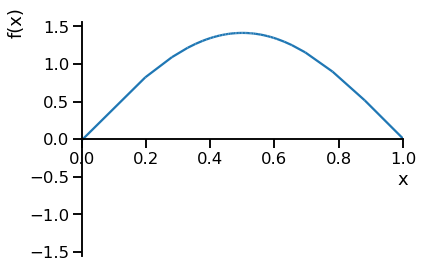

In [5]:
from sympy.plotting import plot

# 可视化基态波函数
plot(psi.subs({l:1}), xlim=(0, 1))

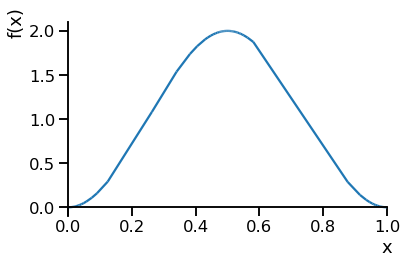

In [6]:
# 可视化粒子数密度 (rho = <psi | psi> )
plot((psi*psi).subs({l:1}), xlim=(0, 1))

In [7]:
## 位置的平均值：积分计算
avg_x = sym.integrate(psi*x*psi, (x, 0, l))

### 化简 simplify 得到平均位置
sym.simplify(avg_x)

l/2

In [8]:
# 检查 sympy 里的虚数符号
sym.I * sym.I

-1

In [9]:
# 检查 sympy 中的微分计算 d psi / dx
sym.diff(psi, x)

sqrt(2)*pi*sqrt(1/l)*cos(pi*x/l)/l

In [10]:
## ## 动量的平均值：微分算子 + 积分计算
hbar = sym.symbols("hbar")

p_rho = psi * (-sym.I * hbar) * sym.diff(psi, x)

avg_p = sym.integrate(p_rho, (x, 0, l))

sym.simplify(avg_p)

0

### 思考：

如何计算坐标的不确定度$\langle \Delta x^2 \rangle $  与动量的不确定度 $\langle \Delta p^2 \rangle$

\begin{align}
\langle \Delta x^2 \rangle &=  \langle x^2 \rangle - \langle x \rangle^2 \\ 
\langle \Delta p^2 \rangle &=  \langle p^2 \rangle - \langle p \rangle^2
\end{align}

In [11]:
##提示： 位置平方的平均值：积分计算
avg_x2 = sym.integrate(psi*x*x*psi, (x, 0, l))
sym.simplify(avg_x2)

-l**2/(2*pi**2) + l**2/3

In [12]:
## 提示：动量平方的平均值 

p2_rho = psi * (-sym.I * hbar)**2 * sym.diff(psi, x, 2)

avg_p2 = sym.integrate(p2_rho, (x, 0, l))

sym.simplify(avg_p2)

Piecewise((pi**2*hbar**2/l**2, (l > -oo) & (l < oo) & Ne(l, 0)), (0, True))

## 2. 最常用的数值积分方法

在工作中，最常用的 python 低维度数值积分方法（比如1维、2维数值积分）是 scipy.integrate.simps() 函数和 scipy.integrate.quad() 函数。

最常用的高维数值积分方法是蒙特卡洛方法，常用的库为 vegas。

这一节先介绍 quad 函数的调用

In [13]:
from scipy.integrate import quad
# 1 维数值积分用 quad
# 2 维数值积分用 dblquad
# 3 维数值积分用 tplquad
# n 维数值积分用 nquad

## help(quad)

举例：可能很多人没意识到，椭圆的周长没有简单的解析公式，只能数值求解，

\begin{align}
{x^2 \over a^2} + {y^2 \over b^2} = 1
\end{align}

设方位角为 $\theta$, 则椭圆上的任一点的坐标可以用 $\theta$ 表示为，

\begin{align}
x &= a \cos \theta \\
y &= b \sin \theta
\end{align}

此时椭圆周长的计算公式为，
\begin{align}
L & = \int dl = \int \sqrt{dx^2 + dy^2}\\
& = \int_0^{2\pi} \sqrt{({dx \over d\theta})^2 + ({dy \over d\theta})^2} d\theta \\
& = \int_0^{2\pi} \sqrt{a^2\sin^2\theta + b^2\cos^2\theta} d\theta
\end{align}

In [14]:
# 验证 sympy 不能给出椭圆周长的解析积分公式

a, b, theta = sym.symbols('a b theta')

L = sym.integrate(sym.sqrt(a**2 * sym.sin(theta)**2 + b**2 * sym.cos(theta)**2), (theta, 0, 2*sym.pi))

In [15]:
sym.simplify(L)

Integral(sqrt(a**2*sin(theta)**2 + b**2*cos(theta)**2), (theta, 0, 2*pi))

In [16]:
def ellipse_circumference(a = 4, b = 3):
    '''计算椭圆周长
    :a: 椭圆长轴长度
    :b: 椭圆短轴长度'''
    f = lambda t: np.sqrt(a**2 * np.sin(t)**2 + b**2 * np.cos(t)**2)
    circum, err = quad(f, 0, 2*np.pi)
    return circum, err

In [17]:
# 首先验证长轴等于短轴时，椭圆周长与圆周长公式相符
circ, err = ellipse_circumference(a=4, b=4)

np.isclose(circ, 2*np.pi * 4)

True

In [18]:
ellipse_circumference(a=4, b=3)

(22.103492160709497, 2.2162729348778595e-08)

In [19]:
## 对比椭圆周长的低阶精度经验公式 L = 2 pi b + 4 (a - b)

def circ_approximate(a, b):
    if b > a: a, b = b, a
    return 2 * np.pi * b + 4 * (a - b)

circ_approximate(a=4, b=3)

22.84955592153876

## 3. 低维数值积分原理介绍

1. 等间距数值积分：牛顿科茨(梯形公式，辛普森积分）
2. 不等间距积分：高斯 quadrature

### 3.1 Newton-Cotes 积分公式: 先插值，再积分

如果已知函数 f(x) 在等间距节点 $x_k$ 上的函数值 $f(x_k)$，其中 $k=0, 1, 2, \cdots, n$

可先用插值法，构造 n-1 阶插值多项式 $f_n(x)$,

\begin{align}
f_n(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_{n-1} x^{n-1}
\end{align}

插值多项式的系数 $a_k(k=0, 1, 2, \cdots, n)$ 通过联立求解 $f_n(x_k) = f(x_k)$ 定出。

多项式 $f_n(x)$ 的微分，积分都可以很快的解析计算。

**拉格朗日插值法** 不使用 $1, x, x^2, \cdots x^{n-1}$ 作为多项式的函数基底，而使用如下基底函数，
\begin{align}
l_k(x) = \Pi_{j=0, j\neq k}^{n} {x - x_j \over x_k - x_j}
\end{align}

此时每个基底 $l_k(x)$ 都是一个 n-1 阶多项式，可以简单验证 
\begin{align}
l_k(x_k) &= 1, \\
l_k(x_j) & = 0, \ for\ j\neq k.
\end{align}

此时，插值多项式为
\begin{align}
f_n(x) = \sum_{k=0}^{n} f(x_k) l_k(x)
\end{align}

此时插值多项式的系数为 $f(x_k)$, 不需要联立求解。

已知 f(x) 的插值多项式近似 $f_n(x)$, 

\begin{align}
\int_a^b f(x) dx \approx \sum_{k=0}^n f(x_k)  \int_a^b l_k(x) =  \sum_{k=0}^n f(x_k) A_k
\end{align}

对 f(x) 的积分等价于对基底函数的积分，再加权求和，权重等于 $f(x_k)$

###  对于 n=2, 只有两个节点

这两个节点等于积分上下限，$x_0=a$, $x_1=b$
\begin{align}
f_2(x) & = f(x_0) {x - x_1 \over x_0 - x_1} + f(x_1) {x - x_0 \over x_1 - x_0}\\
& = f(a) {x - b \over a - b} + f(b) {x - a \over b - a}
\end{align}
此时，得到系数
\begin{align}
A_0 &= \int_a^b {x - b \over a - b} dx \\
A_1 & = \int_a^b {x - a \over b - a} dx
\end{align}

In [20]:
a, b, x = sym.symbols("a b x")

A0 = sym.integrate((x - b)/(a - b), (x, a, b))

A1 = sym.integrate((x - a)/(b - a), (x, a, b))

In [21]:
sym.simplify(A0)

-a/2 + b/2

In [22]:
sym.simplify(A1)

-a/2 + b/2

此时得到一阶 Newton-Cotes 积分公式 -- 梯形公式（上底加 下底，乘高除二等面积），

\begin{align}
F = {b - a \over 2 }\left[ f(a) + f(b) \right]
\end{align}


### 对于 n 个节点，使用 sympy 计算 Newton-Cotes 积分公式

n=3 时，节点分别是 $(x_0, x_1, x_2) = (a, {a+b \over 2}, b)$

n=4 时，等间距节点分别是  $(x_0, x_1, x_2, x_3) = (a, {2a+b \over 3}, {a+2b \over 3},b)$

对等距的 n 个节点，第 k 个节点的坐标可以统一表示为，

\begin{align}
h &= {b - a \over n-1} \\
x_k &= a + k h
\end{align}

In [23]:
def newton_cotes(n=2):
    '''计算 n 个等间距节点的 newton_cotes 积分公式系数
    :return: x_k, A_k where \int f(x) dx = \sum_k A_k f(x_k)
    '''
    h = (b - a) / (n - 1)
    nodes = [a + k*h for k in range(n)]

    x = sym.symbols('x')
    
    def elx(k):
        '''return lagrange interpolation base function l_k(x)'''
        terms = [(x - nodes[j])/(nodes[k] - nodes[j]) 
                 for j in range(n) if j != k]
        
        return sym.prod(terms)
    
    Ak = [sym.integrate(elx(k), (x, a, b)) for k in range(n)]
    
    Ak_s = [sym.simplify(A) for A in Ak]
    
    return nodes, Ak_s

In [24]:
nodes, Ak = newton_cotes(n=3)
Ak

[-a/6 + b/6, -2*a/3 + 2*b/3, -a/6 + b/6]

每项都有 (b-a), 提取出来得到


\begin{align}
\int_a^b f(x) dx \approx \sum_{k=0}^n f(x_k) A_k = (b - a) \sum_{k=0}^n f(x_k) C_k
\end{align}

其中 $C_k = {A_k \over b - a}$

In [25]:
def newton_cotes_coef(n=2):
    '''计算 newton cotes 积分系数 Ck'''
    nodes, Ak = newton_cotes(n=n)
    Ck = [sym.simplify(Ak[k]/(b-a)) for k in range(n)]
    return Ck

newton_cotes_coef(n=3)

[1/6, 2/3, 1/6]

In [26]:
newton_cotes_coef(n=4)

[1/8, 3/8, 3/8, 1/8]

- 3 个节点的 newton cotes 积分对应 2 阶辛普森公式


\begin{align}
F = (b - a)\left[ {1\over 6} f(a) + {2 \over 3} f({a + b \over 2}) + {1 \over 6} f(b) \right]
\end{align}

- 4 个节点的 newton cotes 积分对应 3 阶辛普森公式


\begin{align}
F = (b - a)\left[ {1\over 8} f(a) + {3 \over 8} f({2a + b \over 3}) + {3 \over 8} f({a + 2 b \over 3}) + {1 \over 8} f(b) \right]
\end{align}


一般不对整个区域 [a, b] 直接使用 Newton Cotes 积分公式，

而是把积分区间 [a, b] 化为 n 等分，在每个子区间 $[x_k, x_{k+1}]$ 上使用梯形公式或 Simpson 公式，
最后对所有子区间求和，

这种方法称为 **复化**梯形公式或 **复化** Simpson 公式。


### 作业

1. 编写一个函数，对任意给定函数 f(x) 实现 3 阶 Simpson 数值积分, 并测试对如下函数的积分结果（与 sympy 积分结果对比） 

\begin{align}
\int_{-1}^1 \sqrt{x - 1} dx
\end{align}

2. 编写**复化** Simpson积分函数，子区间个数 n 为可变参数，对每个子区间调用第一题中的 3 阶 Simpson 积分函数

### 3.2 Gauss Quadrature 积分

Newton Cotes 积分使用了等间距节点，n 个节点的 Newton Cotes 积分可以得到 n 次代数精度。

如果不使用等间距节点，可以使用 n 个节点实现 $2 n - 1$ 次代数精度， 这种积分方法称为 **Gauss Quadrature**。

如果需要在自己的程序中做数值积分，大家一般使用 **Gauss Quadrature** 方法。

比如，[-1, 1] 区间的两节点 Gauss Quadrature 积分为，

\begin{align}
\int_{-1}^{1} f(x) dx = A_0 f(x_0) + A_1 f(x_1) = f(- {1 \over \sqrt{3}}) + f({1 \over \sqrt{3}})
\end{align}

其中积分节点 $x_0 = - {1 \over \sqrt{3}}$, $x_1 = {1 \over \sqrt{3}}$ 不在端点, 权重 $A_0=A_1=1$。

对比梯形公式,


\begin{align}
\int_{-1}^{1} f(x) dx = f(-1) + f(1)
\end{align}
 两个节点为端点 $x_0 = - 1$, $x_1 = 1$，${b - a \over 2 }=1$。

In [27]:
# 简单举例  \int_{-1}^{1} sqrt(1 - x)

# 定义被积函数
def f(x):
    return np.sqrt(1 - x)

Text(-0.75, 0.19999999999999996, '$f(-1/\\sqrt{3}) + f(1/\\sqrt{3}) = 1.906041$')

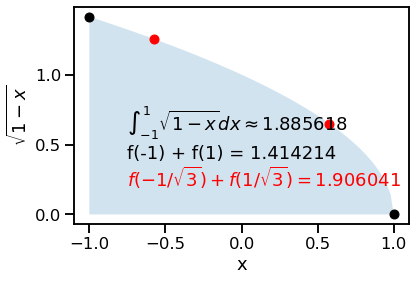

In [28]:
x = np.linspace(-1, 1, 100)
# 画图：函数及其积分区域
plt.fill_between(x, np.zeros_like(x), f(x), 
                 alpha=0.2)   # for color 
plt.xlabel('x')
plt.ylabel(r'$\sqrt{1-x}$')

# 计算对 f(x) 的数值积分
area, err = quad(f, -1, 1)
xg = 1/np.sqrt(3.0)
plt.plot([-xg, xg], [f(-xg), f(xg)], 'ro' )
plt.plot([-1, 1], [f(-1), f(1)], 'ko' )
xtxt, ytxt = -0.75, 0.6
plt.text(xtxt, ytxt, r'$\int_{-1}^{1} \sqrt{1-x} dx \approx %.6f$'%area)
plt.text(xtxt, ytxt-0.2, 'f(-1) + f(1) = %.6f'%(f(-1) + f(1)))
plt.text(xtxt, ytxt-0.4, r'$f(-1/\sqrt{3}) + f(1/\sqrt{3}) = %.6f$'%(f(-1/np.sqrt(3)) + f(1/np.sqrt(3))), color='r')

In [29]:
## 查表得到 5 个节点的 Gauss-Legendre 求积节点 x_k 与权重 A_k

c1, c2 = 0.906180, 0.538469

a1, a2, a3 = 0.236927, 0.478629, 0.568889
# 节点 xk
xk = np.array([-c1, -c2, 0, c2, c1])

# 权重 Ak
ak = np.array([a1, a2, a3, a2, a1])

result = (ak * f(xk)).sum()

print("gauss5p = %.6f"%result)
print("quad(f, -1, 1)[0]=%.6f"%(quad(f, -1, 1)[0]))

gauss5p = 1.887401
quad(f, -1, 1)[0]=1.885618


Gauss quadrature 是比较成熟的积分方法，一般使用时直接查表，很少需要手动构造求积节点和权重。

这里为了教育目的，解释 Gauss Quadrature 的节点与权重构造方法。

比如，
- 如何得到 $\int_{-1}^{1} f(x) dx \approx f(-1/\sqrt{3}) +  f(1/\sqrt{3})$ 的节点? 
- 如何得到上面 5 点 Gauss 积分那些奇怪的节点和权重因子？

前面说 Gauss Quadrature 可以用 n 个节点构造 2n-1 次代数精度的积分，

它的含义是：只要 f(x) 是一个不高于 2n - 1 次的多项式，Gauss Quadrature 都是严格的解析积分。

即对于 n=2, 我们需要选取 2 个节点，2 个权重，使得对 $f(x) = 1, x, x^2, x^3$，

数值积分的结果$\int_{-1}^{1} f(x) dx = A_0 f(x_0) + A_1 f(x_1)$ 严格等于解析积分，

\begin{align}
f(x)=1, & & A_0 + A_1 = 2 \\
f(x)=x, & & A_0 x_0 + A_1 x_1 = 0 \\
f(x)=x^2, & & A_0 x_0^2 + A_1 x_1^2 = {2\over 3} \\
f(x)=x^3, & & A_0 x_0^3 + A_1 x_1^3= 0 \\
\end{align}

四个未知数($x_0, x_1, A_0, A_1$), 四个方程，刚好可以求出所有的节点和权重。

In [29]:
a0, a1, x0, x1 = sym.symbols("A_0, A_1, x_0, x_1")

sym.nonlinsolve([a0 + a1 - 2, 
                 a0*x0 + a1*x1,
                 a0*x0**2 + a1*x1**2 - sym.Rational(2, 3),
                 a0*x0**3 + a1*x1**3],
               [a0, a1, x0, x1])

FiniteSet((1, 1, -sqrt(3)/3, sqrt(3)/3), (1, 1, sqrt(3)/3, -sqrt(3)/3))

为了得到高斯积分的 n 个节点和 n 个权重，需要联立求解 2n 个方程的非线性方程组，比较困难。

如果使用带权重 $\rho(x)$ 的正交多项式展开，则节点可选为 $\phi_{n+1}(x)$ 的根 $x_i$ (i=0,1,...n), 积分系数可以直接计算，

\begin{align}
\int_a^b \rho(x) f(x) dx &= \sum_{k=0}^n A_k f(x_k) \\
 A_k &= \int_a^b \rho(x) l_k(x) dx
\end{align}

其中 $l_k(x)$ 是基于高斯节点的 Lagrange 插值基函数。（参考 Newton-Cortes 积分公式使用 Lagrange 插值加速计算的技巧）

带权函数的正交多项式的概念（参考 数值分析，李红：第三章函数逼近与曲线拟合）。

### 常用的 Gauss 型求积公式

1. Gauss-Legendre 求积公式，权函数 $\rho(x) = 1$
2. Gauss-Chebyshev 求积公式，权函数 $\rho(x) = 1/\sqrt{1-x^2}$
3. Gauss-Laguerre 求积公式，权函数 $\rho(x) = e^{-x}$

https://mathworld.wolfram.com/GaussianQuadrature.html

numpy有对应的模块计算高斯积分的节点与权值，

- Gauss-Legendre:
节点和权值：numpy.polynomial.legendre.leggauss(n)

- Gauss-Chebyshev:
节点和权值：numpy.polynomial.chebyshev.chebgauss(n)

- Gauss-Laguerre:
节点和权值：numpy.polynomial.laguerre.laggauss(n)

- Gauss-Hermite:
节点和权值：numpy.polynomial.hermite.hermgauss(n)

In [30]:
# 可与之前的 5 点 Gauss 积分节点和权值对比

nodes, weights = np.polynomial.legendre.leggauss(deg=5)

print("Gauss-Legendre 5 points: nodes =", nodes)

print("Gauss-Legendre 5 points: weights =", weights)

Gauss-Legendre 5 points: nodes = [-0.90617985 -0.53846931  0.          0.53846931  0.90617985]
Gauss-Legendre 5 points: weights = [0.23692689 0.47862867 0.56888889 0.47862867 0.23692689]


In [31]:
nodes, weights = np.polynomial.chebyshev.chebgauss(deg=5)

print("Gauss-Chebyshev 5 points: nodes =", nodes)

print("Gauss-Chebyshev 5 points: weights =", weights)

Gauss-Chebyshev 5 points: nodes = [ 9.51056516e-01  5.87785252e-01  6.12323400e-17 -5.87785252e-01
 -9.51056516e-01]
Gauss-Chebyshev 5 points: weights = [0.62831853 0.62831853 0.62831853 0.62831853 0.62831853]


### 举例：实现 n 点 Gauss Chebyshev 积分公式，

注意 Gauss Chebyshev 的权函数为 $\rho(x) = {1 \over \sqrt{1-x^2}}$, 积分公式为，

\begin{align}
\int_{-1}^{1}  {1 \over \sqrt{1-x^2}} f(x) dx = \sum_i w_i f(x_i)
\end{align}

In [32]:
def GaussChebyshev(func, deg=5):
    xk, Ak = np.polynomial.chebyshev.chebgauss(deg=deg)
    rho = 1/np.sqrt(1 - xk**2)
    fxk = func(xk) / rho
    return (Ak * fxk).sum()

print("quad(f, -1, 1)=", quad(f, -1, 1))
print("GaussChebyshev(f, deg=5)=", GaussChebyshev(f, deg=5))
print("GaussChebyshev(f, deg=15)=", GaussChebyshev(f, deg=15))
print("GaussChebyshev(f, deg=25)=", GaussChebyshev(f, deg=25))

quad(f, -1, 1)= (1.8856180831641267, 2.093456611578367e-15)
GaussChebyshev(f, deg=5)= 1.9093605951233406
GaussChebyshev(f, deg=15)= 1.8882086494251886
GaussChebyshev(f, deg=25)= 1.8865493490832632
